# Source Detection

This notebook is an attempt to split out the source detection and measurement algorithms from `processCCD` and apply them to the search for low surface brightness galaxies. This builds off Robert Lupton's [Greco LSB.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Greco%20LSB.ipynb) with some source detection and measurement details from [Tune Detection.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Tune%20Detection.ipynb) and [Kron.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Kron.ipynb).

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

from matplotlib.patches import Rectangle

In [3]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

import lsst.daf.persistence        as dafPersist
import lsst.afw.display            as afwDisplay
import lsst.afw.table              as afwTable

In [4]:
datadir = "/project/shared/data/Twinkles_subset/output_data_v2"
butler = dafPersist.Butler(datadir)

In [5]:
def smooth_gauss (masked_image, sigma, nsigma=1.0):
    width = (int(sigma*nsigma + 0.5) // 2)*2 + 1
    gauss_func = afwMath.GaussianFunction1D(sigma)
    gauss_kern = afwMath.SeparableKernel(width, width, gauss_func, gauss_func)
    convolved_image = masked_image.Factory(masked_image.getBBox())
    afwMath.convolve(convolved_image, masked_image, gauss_kern, 
                     afwMath.ConvolutionControl())
    return convolved_image

def display_image(image, figsize=(15,5)):
    fig, ax = plt.subplots(figsize=figsize)
    vmin, vmax = zscale.get_limits(image)
    ax.imshow(image, vmin=vmin, vmax=vmax, cmap='gray_r', 
              aspect='equal', origin='lower')
    ax.axis('off')
    return ax

In [6]:
print(butler.queryMetadata('calexp', ['visit','raft','sensor']))
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}
calexp = butler.get('calexp', **dataId)

[(230, '2,2', '1,1'), (231, '2,2', '1,1'), (232, '2,2', '1,1'), (233, '2,2', '1,1'), (234, '2,2', '1,1'), (235, '2,2', '1,1'), (236, '2,2', '1,1'), (237, '2,2', '1,1'), (238, '2,2', '1,1'), (239, '2,2', '1,1'), (250, '2,2', '1,1'), (251, '2,2', '1,1'), (252, '2,2', '1,1'), (253, '2,2', '1,1'), (254, '2,2', '1,1'), (255, '2,2', '1,1'), (256, '2,2', '1,1'), (257, '2,2', '1,1'), (258, '2,2', '1,1'), (259, '2,2', '1,1'), (260, '2,2', '1,1'), (261, '2,2', '1,1'), (262, '2,2', '1,1'), (263, '2,2', '1,1'), (264, '2,2', '1,1'), (265, '2,2', '1,1'), (266, '2,2', '1,1'), (267, '2,2', '1,1'), (268, '2,2', '1,1'), (269, '2,2', '1,1'), (280, '2,2', '1,1'), (281, '2,2', '1,1'), (282, '2,2', '1,1'), (283, '2,2', '1,1'), (284, '2,2', '1,1'), (285, '2,2', '1,1'), (286, '2,2', '1,1'), (287, '2,2', '1,1'), (288, '2,2', '1,1'), (289, '2,2', '1,1'), (306, '2,2', '1,1'), (307, '2,2', '1,1'), (308, '2,2', '1,1'), (309, '2,2', '1,1'), (310, '2,2', '1,1'), (311, '2,2', '1,1'), (312, '2,2', '1,1'), (313, '2,2',

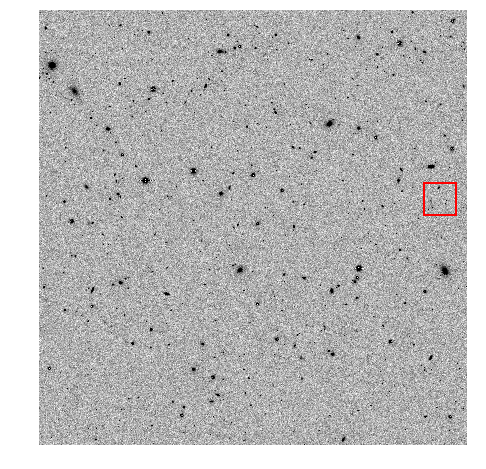

In [7]:
display_image(calexp.getMaskedImage().getImage().getArray(), figsize=(8,8));
xmin,ymin = 3600,2150
width,height=300,300
rect = Rectangle((xmin,ymin),width,height,facecolor='none',edgecolor='r',lw=2)
plt.gca().add_artist(rect)

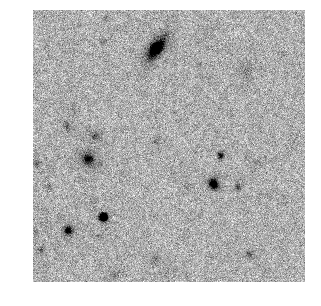

In [9]:
# Zoom to a small region of the image
bbox = afwGeom.Box2I()
bbox.include(afwGeom.Point2I(xmin, ymin))
bbox.include(afwGeom.Point2I(xmin+width, ymin+height))
exp_cutout = calexp.Factory(calexp, bbox, afwImage.LOCAL)

mi = exp_cutout.getMaskedImage()
#mask = mi.getMask()
## Careful, this is clearing the mask plane of the parent calexp
#mask.removeAndClearMaskPlane('CR', True)

display_image(mi.getImage().getArray());

In [ ]:
mi = calexp.getMaskedImage()
mask = mi.getMask()
mask.getMaskPlaneDict()

# Source Detection and Measurement

We now want to run the LSST source detection and measurement tasks.

In [10]:
# Importing the tasks
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask
from lsst.pipe.tasks.calibrate         import CalibrateTask
from lsst.meas.algorithms.detection    import SourceDetectionTask
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask

In [11]:
# Create the Tasks
schema = afwTable.SourceTable.makeMinimalSchema()
algMetadata = dafBase.PropertyList()

config = CharacterizeImageTask.ConfigClass()
config.psfIterations = 1
charImageTask =         CharacterizeImageTask(None, config=config)

config = SourceDetectionTask.ConfigClass()

# SourceDetectionTask.thresholdType: 
#print(SourceDetectionTask.ConfigClass.thresholdType.__doc__)
if True:
    config.thresholdValue = 30       # detection threshold in units of thresholdType
    config.thresholdType = "stdev"   # units for thresholdValue
if False:                    
    config.doTempLocalBackground = True  # Use local-background during detection step

sourceDetectionTask =   SourceDetectionTask(schema=schema, config=config)
sourceDeblendTask   =   SourceDeblendTask(schema=schema)

config = SingleFrameMeasurementTask.ConfigClass()
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=config,
                                                   algMetadata=algMetadata)

In [15]:
tab = afwTable.SourceTable.make(schema)

# Image characterization
result = charImageTask.characterize(calexp)

# Source detection
result = sourceDetectionTask.run(tab, calexp)
sources = result.sources
# Source deblending
sourceDeblendTask.run(calexp, sources)
# Source measurement
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

if False:
    sources.writeFits("outputTable.fits")
    exposure.writeFits("example1-out.fits")

In [13]:
help(sourceMeasurementTask.run)

Help on method run in module lsst.meas.base.sfm:

run(measCat, exposure, noiseImage=None, exposureId=None, beginOrder=None, endOrder=None) method of lsst.meas.base.sfm.SingleFrameMeasurementTask instance
    !
    Run single frame measurement over an exposure and source catalog
    
    @param[in,out]  measCat  lsst.afw.table.SourceCatalog to be filled with outputs.  Must
                             contain all the SourceRecords to be measured (with Footprints
                             attached), and have a schema that is a superset of self.schema.
    
    @param[in] exposure      lsst.afw.image.ExposureF, containing the pixel data to
                             be measured and the associated Psf, Wcs, etc.
    @param[in] noiseImage    optional lsst.afw.image.ImageF for test which need to control
                             noiseReplacement
    @param[in] exposureId    optional unique exposureId used to calculate random number
                             generator seed in the N